Import packages for Problem 1

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.optimize import curve_fit

### Initializing SIR_model and Gillespie's Algorithm functions

In [44]:
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / (S + I + R)
    dI_dt = beta * S * I / (S + I + R) - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def SIR_demography(y, t, beta, gamma, Lambda, mu):
    S, I, R = y
    dS_dt = Lambda - beta * S * I / (S + I + R) - mu * S
    dI_dt = beta * S * I / (S + I + R) - gamma * I - mu * I
    dR_dt = gamma * I - mu * R
    return [dS_dt, dI_dt, dR_dt]

def gillespie_algorithm(S0, I0, R0, beta, gamma, max_time):
    S, I, R = S0, I0, R0
    t = 0
    times = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]

    while t < max_time and I > 0:
        N = S + I + R

        # Calculate propensities
        a1 = beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        # Time until next event
        dt = -np.log(np.random.random()) / a0
        t += dt

        # Determine which event occurs
        r = np.random.random()
        if r < a1 / a0:
            # Transmission event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)

    return times, S_values, I_values, R_values

def GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time):
    S, I, R = S0, I0, R0
    t = 0
    times = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]

    while t < max_time and I > 0:
        N = S + I + R

        # Calculate propensities
        a1 = beta * S * I / N        # Transmission
        a2 = gamma * I               # Recovery
        a3 = Lambda                  # Birth
        a4 = mu * S                  # Death of a susceptible
        a5 = mu * I                  # Death of an infected
        a6 = mu * R                  # Death of a recovered
        
        a0 = a1 + a2 + a3 + a4 + a5 + a6

        # Time until next event
        dt = -np.log(np.random.random()) / a0
        t += dt

        # Determine which event occurs
        r = np.random.random() * a0
        if r < a1:
            # Transmission event
            S -= 1
            I += 1
        elif r < a1 + a2:
            # Recovery event
            I -= 1
            R += 1
        elif r < a1 + a2 + a3:
            # Birth event
            S += 1
        elif r < a1 + a2 + a3 + a4:
            # Death of a susceptible
            S -= 1
        elif r < a1 + a2 + a3 + a4 + a5:
            # Death of an infected
            I -= 1
        else:
            # Death of a recovered
            R -= 1

        # Store results
        times.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)

    return times, S_values, I_values, R_values

We set the transmission rate to 0.3, recovery rate to 0.1. The initial number of susceptible and infected individuals can vary, the initial number of recovered individual is always 0. We can also set how many times we want to run the Gillespie's Algorithm.

In [45]:
# SIR model without demography
beta = 0.3
gamma = 0.1
max_time = 200
t = np.linspace(0, max_time, 1000)
output = widgets.Output()

def update_plot(S0, I0, num_runs):
    R0 = 0
    fig, ax = plt.subplots(figsize=(10, 6))

    # Solve ODE for deterministic SIR
    solution = odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))
    S_det, I_det, R_det = solution.T

    # Run Gillespie algorithm multiple times
    all_S = []
    all_I = []
    all_R = []

    for _ in range(num_runs):
        times, S_values, I_values, R_values = gillespie_algorithm(S0, I0, R0, beta, gamma, max_time)
        all_S.append(np.interp(t, times, S_values))
        all_I.append(np.interp(t, times, I_values))
        all_R.append(np.interp(t, times, R_values))

    # Compute average and standard deviation
    avg_S = np.mean(all_S, axis=0)
    std_S = np.std(all_S, axis=0)
    avg_I = np.mean(all_I, axis=0)
    std_I = np.std(all_I, axis=0)

    # Deterministic SIR
    ax.plot(t, S_det, label="Susceptible (Deterministic)", linestyle="--")
    ax.plot(t, I_det, label="Infectious (Deterministic)", linestyle="--")

    # Average Stochastic SIR
    ax.plot(t, avg_S, label="Avg Susceptible (Stochastic)")
    ax.fill_between(t, avg_S - std_S, avg_S + std_S, alpha=0.2)
    ax.plot(t, avg_I, label="Avg Infectious (Stochastic)")
    ax.fill_between(t, avg_I - std_I, avg_I + std_I, alpha=0.2)

    ax.set_xlabel("Time")
    ax.set_ylabel("Population")
    ax.set_title(f"Comparison of Deterministic and Stochastic SIR Models ({num_runs} runs)")
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    

S0_slider = widgets.IntSlider(value=990, min=0, max=1000, step=10, description='S0:')
I0_slider = widgets.IntSlider(value=10, min=0, max=100, step=10, description='I0:')
num_runs_slider = widgets.IntSlider(value=1000, min=1, max=1000, description='GA Run:')


widgets.interactive(update_plot, S0=S0_slider, I0=I0_slider, num_runs=num_runs_slider)

interactive(children=(IntSlider(value=990, description='S0:', max=1000, step=10), IntSlider(value=10, descript…

In [46]:
# SIR model with demography
beta = 0.3
gamma = 0.1
Lambda = 5  # birth rate
mu = 0.01  # death rate
max_time = 200
t = np.linspace(0, max_time, 1000)
output = widgets.Output()

def update_plot(S0, I0, num_runs):
    R0 = 0
    with output:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 6))
    
        # Solve ODE for deterministic SIR
        solution = odeint(SIR_demography, [S0, I0, R0], t, args=(beta, gamma, Lambda, mu))
        S_det, I_det, R_det = solution.T

        # Run Gillespie algorithm multiple times
        all_S = []
        all_I = []
        all_R = []

        for _ in range(num_runs):
            times, S_values, I_values, R_values = GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time)
            all_S.append(np.interp(t, times, S_values))
            all_I.append(np.interp(t, times, I_values))
            all_R.append(np.interp(t, times, R_values))

        # Compute average and standard deviation
        avg_S = np.mean(all_S, axis=0)
        std_S = np.std(all_S, axis=0)
        avg_I = np.mean(all_I, axis=0)
        std_I = np.std(all_I, axis=0)

        # Deterministic SIR
        ax.plot(t, S_det, color='cornflowerblue', label="Susceptible (Deterministic)", linestyle="--")
        ax.plot(t, I_det, color='purple', label="Infectious (Deterministic)", linestyle="--")

        # Average Stochastic SIR
        ax.plot(t, avg_S, color='green', label="Avg Susceptible (Stochastic)")
        ax.fill_between(t, avg_S - std_S, avg_S + std_S, color='green', alpha=0.2)
        ax.plot(t, avg_I, color='red', label="Avg Infectious (Stochastic)")
        ax.fill_between(t, avg_I - std_I, avg_I + std_I, color='red', alpha=0.2)

        ax.set_xlabel("Time")
        ax.set_ylabel("Population")
        ax.set_title(f"Comparison of Deterministic and Stochastic SIR Models with Demography ({num_runs} runs)")
        ax.legend(loc="upper right")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

S0_slider = widgets.IntSlider(value=90, min=0, max=1000, step=10, description='S0:')
I0_slider = widgets.IntSlider(value=10, min=0, max=100, step=10, description='I0:')
num_runs_slider = widgets.IntSlider(value=1, min=1, max=1000, description='GA Run:')


interactive_plot = widgets.interactive(update_plot, S0=S0_slider, I0=I0_slider, num_runs=num_runs_slider)
display(interactive_plot, output)

interactive(children=(IntSlider(value=90, description='S0:', max=1000, step=10), IntSlider(value=10, descripti…

Output()

### Tau-leaping for noise control

In [47]:
def GA_with_tau_leaping(S0, I0, R0, beta, gamma, Lambda, mu, max_time, tau):
    S, I, R = S0, I0, R0
    t = 0
    times = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]

    while t < max_time and I > 0:
        N = S + I + R

        # Calculate propensities
        a1 = beta * S * I / N
        a2 = gamma * I
        a3 = Lambda
        a4 = mu * S
        a5 = mu * I
        a6 = mu * R
        
        # Estimate number of reactions in the time interval tau
        num_a1 = np.random.poisson(a1 * tau)
        num_a2 = np.random.poisson(a2 * tau)
        num_a3 = np.random.poisson(a3 * tau)
        num_a4 = np.random.poisson(a4 * tau)
        num_a5 = np.random.poisson(a5 * tau)
        num_a6 = np.random.poisson(a6 * tau)

        # Update states based on estimated number of reactions
        S += num_a3 - num_a1 - num_a4
        I += num_a1 - num_a2 - num_a5
        R += num_a2 - num_a6

        t += tau

        # Store results
        times.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)

    return times, S_values, I_values, R_values

In [48]:
# SIR model with demography
beta = 0.3
gamma = 0.1
Lambda = 5 
mu = 0.01 
max_time = 200
t = np.linspace(0, max_time, 1000)
output = widgets.Output()

def SIR_demography(Y, t, beta, gamma, Lambda, mu):
    S, I, R = Y

    N = S + I + R
    dS = Lambda - beta * S * I / N - mu * S
    dI = beta * S * I / N - gamma * I - mu * I
    dR = gamma * I - mu * R

    return [dS, dI, dR]

def update_plot(S0, I0, tau, num_runs):
    R0 = 0
    with output:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 6))
    
        solution = odeint(SIR_demography, [S0, I0, R0], t, args=(beta, gamma, Lambda, mu))
        S_det, I_det, R_det = solution.T

        all_S_GA = []
        all_I_GA = []
        all_S_tau = []
        all_I_tau = []

        for _ in range(num_runs):
            times_GA, S_values_GA, I_values_GA, R_values_GA = GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time)
            times_tau, S_values_tau, I_values_tau, R_values_tau = GA_with_tau_leaping(S0, I0, R0, beta, gamma, Lambda, mu, max_time, tau=0.2)

            all_S_GA.append(np.interp(t, times_GA, S_values_GA))
            all_I_GA.append(np.interp(t, times_GA, I_values_GA))
            all_S_tau.append(np.interp(t, times_tau, S_values_tau))
            all_I_tau.append(np.interp(t, times_tau, I_values_tau))

        # Compute averages and standard deviations for both algorithms
        avg_S_GA = np.mean(all_S_GA, axis=0)
        std_S_GA = np.std(all_S_GA, axis=0)
        avg_I_GA = np.mean(all_I_GA, axis=0)
        std_I_GA = np.std(all_I_GA, axis=0)
        avg_S_tau = np.mean(all_S_tau, axis=0)
        std_S_tau = np.std(all_S_tau, axis=0)
        avg_I_tau = np.mean(all_I_tau, axis=0)
        std_I_tau = np.std(all_I_tau, axis=0)

        # Deterministic SIR
        ax.plot(t, S_det, color='cornflowerblue', label="Susceptible (Deterministic)", linestyle="--")
        ax.plot(t, I_det, color='purple', label="Infectious (Deterministic)", linestyle="--")

        # Average Stochastic SIR using GA
        ax.plot(t, avg_S_GA, color='green', label="Avg Susceptible (GA)")
        ax.fill_between(t, avg_S_GA - std_S_GA, avg_S_GA + std_S_GA, color='green', alpha=0.2)
        ax.plot(t, avg_I_GA, color='red', label="Avg Infectious (GA)")
        ax.fill_between(t, avg_I_GA - std_I_GA, avg_I_GA + std_I_GA, color='red', alpha=0.2)

        # Average Stochastic SIR using Tau-Leaping
        ax.plot(t, avg_S_tau, color='darkcyan', label="Avg Susceptible (Tau-Leaping)")
        ax.fill_between(t, avg_S_tau - std_S_tau, avg_S_tau + std_S_tau, color='darkcyan', alpha=0.2)
        ax.plot(t, avg_I_tau, color='orange', label="Avg Infectious (Tau-Leaping)")
        ax.fill_between(t, avg_I_tau - std_I_tau, avg_I_tau + std_I_tau, color='orange', alpha=0.2)

        ax.set_xlabel("Time")
        ax.set_ylabel("Population")
        ax.set_title(f"Comparison of Deterministic, GA, and Tau-Leaping ({num_runs} runs)")
        ax.legend(loc="center right")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

S0_slider = widgets.IntSlider(value=90, min=0, max=1000, step=10, description='S0:')
I0_slider = widgets.IntSlider(value=10, min=0, max=100, step=10, description='I0:')
tau_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1000.0, step=0.1, description='tau:')
num_runs_slider = widgets.IntSlider(value=1, min=1, max=1000, description='Runs:')

interactive_plot = widgets.interactive(update_plot, S0=S0_slider, I0=I0_slider, tau=tau_slider, num_runs=num_runs_slider)
display(interactive_plot, output)

interactive(children=(IntSlider(value=90, description='S0:', max=1000, step=10), IntSlider(value=10, descripti…

Output()

### Investigate Simulation Variability and Negative Co-variance

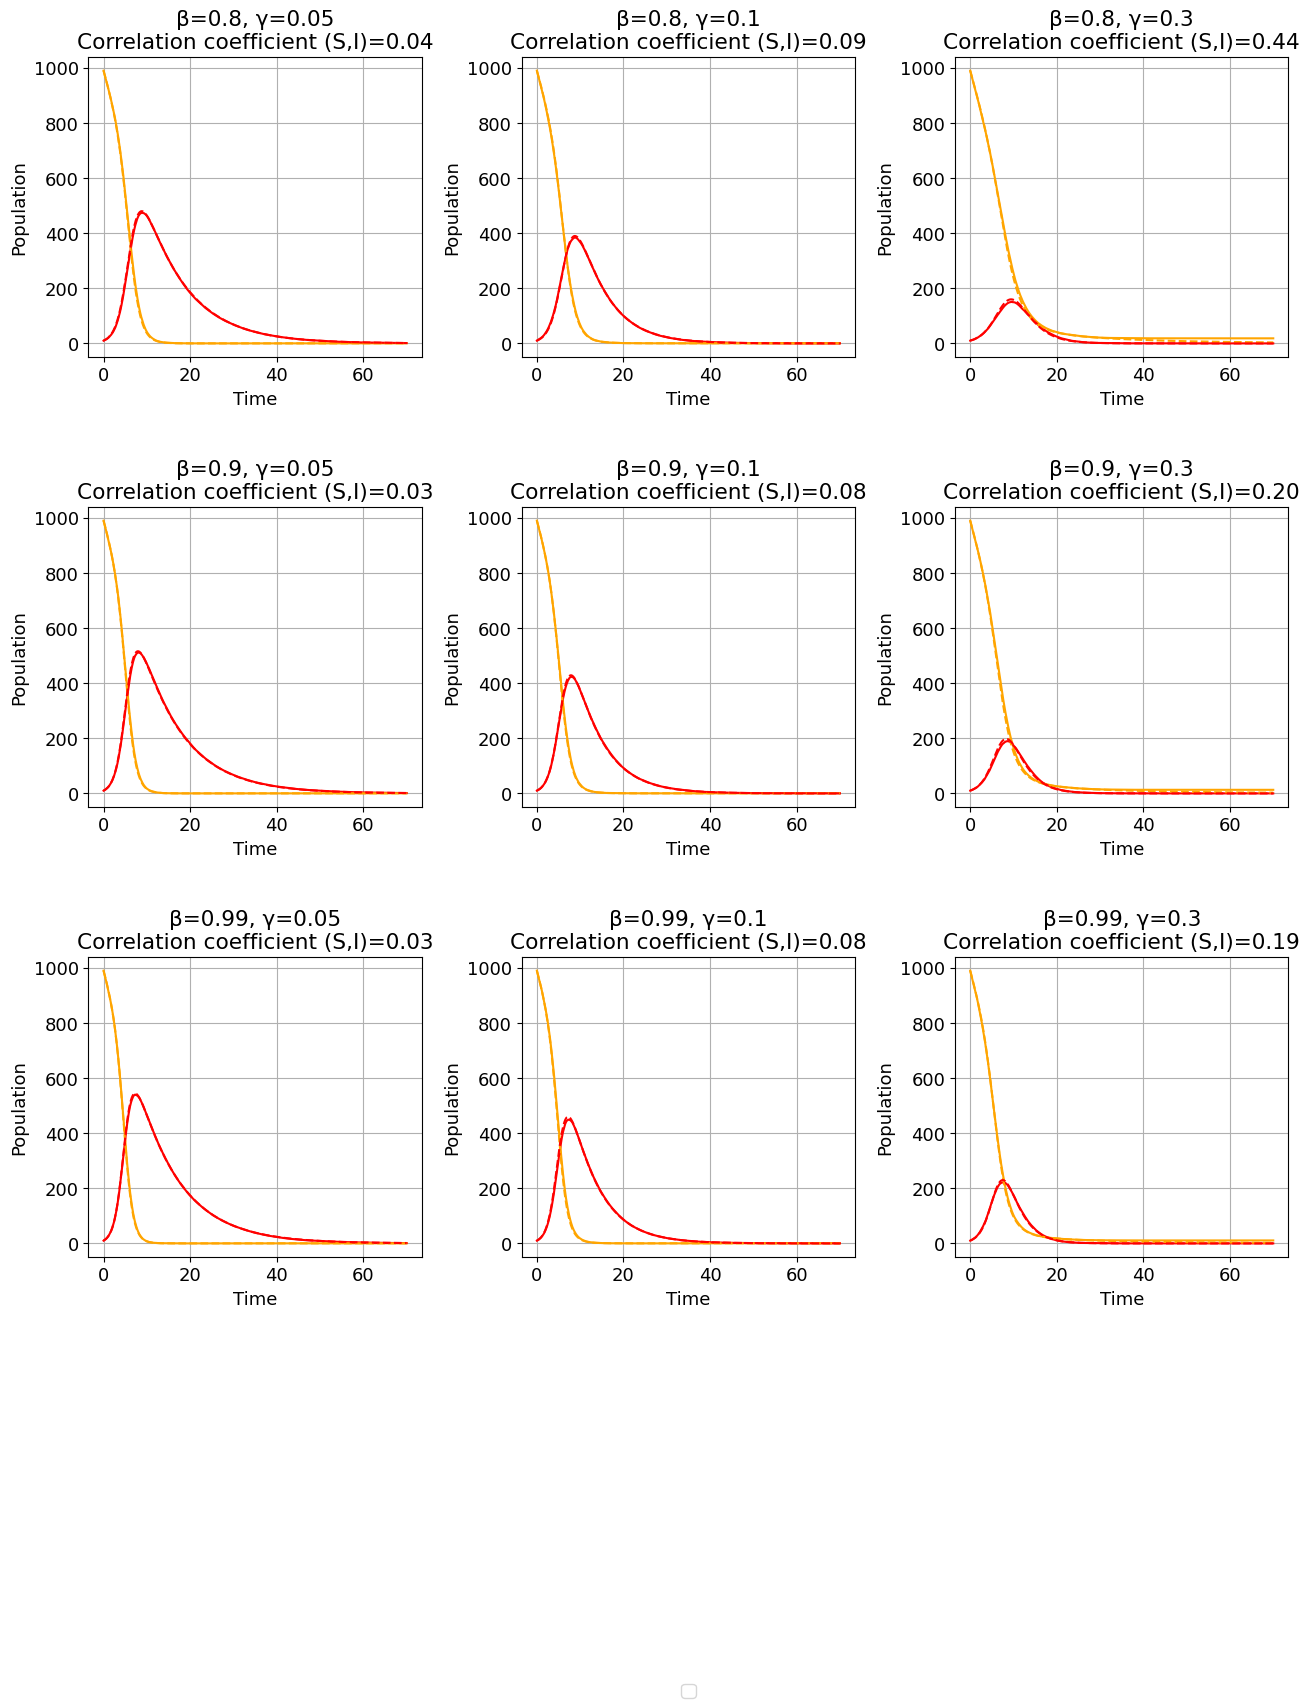

In [49]:
def GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time):
    # Initial conditions
    S, I, R = S0, I0, R0
    t = 0
    times = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]

    while t < max_time and I > 0:
        N = S + I + R

        # Calculate propensities
        a1 = beta * S * I / N        # Transmission
        a2 = gamma * I               # Recovery
        a3 = Lambda                  # Birth
        a4 = mu * S                  # Death of a susceptible
        a5 = mu * I                  # Death of an infected
        a6 = mu * R                  # Death of a recovered
        
        a0 = a1 + a2 + a3 + a4 + a5 + a6

        # Time until next event
        dt = -np.log(np.random.random()) / a0
        t += dt

        # Determine which event occurs
        r = np.random.random() * a0
        if r < a1:
            # Transmission event
            S -= 1
            I += 1
        elif r < a1 + a2:
            # Recovery event
            I -= 1
            R += 1
        elif r < a1 + a2 + a3:
            # Birth event
            S += 1
        elif r < a1 + a2 + a3 + a4:
            # Death of a susceptible
            S -= 1
        elif r < a1 + a2 + a3 + a4 + a5:
            # Death of an infected
            I -= 1
        else:
            # Death of a recovered
            R -= 1

        # Store results
        times.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)

    return times, S_values, I_values, R_values

# Parameters
S0= 990
I0= 10
R0= 0
Lambda = 0.05  # birth rate
mu = 0.05  # death rate
max_time = 70
t = np.linspace(0, max_time, 1000)

# Parameters
beta_values = [0.8, 0.9, 0.99]
gamma_values = [0.05, 0.1, 0.3]
num_runs = 100

results = []


for beta in beta_values:
    for gamma in gamma_values:
        all_S = []
        all_I = []
        end_times = []
        for _ in range(num_runs):
            times, S_values, I_values, _ = GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time)

            S_interp = np.interp(t, times, S_values)
            I_interp = np.interp(t, times, I_values)
            
            below_10_percent = np.where(I_interp <= 0.1 * I0)[0]
            if below_10_percent.size > 0:
                end_time = t[below_10_percent[0]]
                end_times.append(end_time)

            all_S.append(S_interp)
            all_I.append(I_interp)

        if not end_times:
            continue

        end_time=max(end_times)

        # Covariance experiment
        start_time = 0
        start_index = np.where(t >= start_time)[0][0]
        end_index = np.where(t <= end_time)[0][-1] + 1

        # Compute mean and covariance
        mean_S = np.mean(all_S, axis=0)
        mean_I = np.mean(all_I, axis=0)
        mean_S_mod = np.mean([s[start_index:end_index] for s in all_S], axis=0)
        mean_I_mod = np.mean([i[start_index:end_index] for i in all_I], axis=0)
        std_S = np.std(S_values, axis=0)
        std_I = np.std(I_values, axis=0)
        covariance_SI = np.cov(mean_S_mod, mean_I_mod)[0, 1]
        corr_coefficient = covariance_SI / (std_S * std_I)

        # Run deterministic model
        solution = odeint(SIR_demography, [S0, I0, R0], t, args=(beta, gamma, Lambda, mu))
        S_det, I_det, R_det = solution.T

        # Store results
        results.append({
            'beta': beta,
            'gamma': gamma,
            'mean_S': mean_S,
            'mean_I': mean_I,
            'covariance_SI': covariance_SI,
            'corr_coefficient': corr_coefficient,
            'S_det': S_det,
            'I_det': I_det
        })

# Create a grid of subplots
num_beta = len(beta_values)
num_gamma = len(gamma_values)
fig, axes = plt.subplots(num_beta, num_gamma, figsize=(15, 15))

first_plot = True

for i, res in enumerate(results):
    ax = axes[i // num_gamma][i % num_gamma]
    
    ax.plot(t, res['mean_S'], label="Mean Susceptible (Stochastic)" if first_plot else "", color="orange")
    ax.plot(t, res['mean_I'], label="Mean Infectious (Stochastic)" if first_plot else "", color="red")
    ax.plot(t, res['S_det'], label="Susceptible (Deterministic)" if first_plot else "", color="orange", linestyle="--")
    ax.plot(t, res['I_det'], label="Infectious (Deterministic)" if first_plot else "", color="red", linestyle="--")
    
    ax.set_title(f"β={res['beta']}, γ={res['gamma']}\nCorrelation coefficient (S,I)={res['corr_coefficient']:.2f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Population")
    ax.grid(True)
    
    
    first_plot = False

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))

plt.show()

### Stochastic Resonance and Increased Transients

In [50]:
# Parameters
S0= 990
I0=10
R0=0
gamma = 0.1 
Lambda = 5  # birth rate
mu = 0.01  # death rate
max_time = 200
t = np.linspace(0, max_time, 1000)
N_values = np.linspace(100, 5000, 25).astype(int)  
R0_values = np.linspace(2.0, 10.0, 25)
gamma = 0.1 
max_time = 160
t_common = np.linspace(0, max_time, 1000)
num_runs = 100

transients = []

transient_S_matrix = np.zeros((len(N_values), len(R0_values)))
transient_I_matrix = np.zeros((len(N_values), len(R0_values)))

def measure_transient(stochastic, deterministic):
    absolute_transient = np.max(np.abs(stochastic - deterministic))
    return absolute_transient / np.max(deterministic)


for i, N in enumerate(N_values):
    for j, R0 in enumerate(R0_values):
        beta = R0 * gamma
        
        I0 = 5
        S0 = N - I0 - R0

        S_accum = np.zeros_like(t_common)
        I_accum = np.zeros_like(t_common)
        
        for _ in range(num_runs):
            times, S_stoch, I_stoch, R_stoch = GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time)
            
            S_stoch_interp = np.interp(t_common, times, S_stoch)
            I_stoch_interp = np.interp(t_common, times, I_stoch)
            
            S_accum += S_stoch_interp
            I_accum += I_stoch_interp
        
        S_stoch_mean = S_accum / num_runs
        I_stoch_mean = I_accum / num_runs
        
        solution = odeint(SIR_demography, [S0, I0, R0], t, args=(beta, gamma, Lambda, mu))
        S_det, I_det, R_det = solution.T
        
        transient_S = measure_transient(S_stoch_mean, S_det)
        transient_I = measure_transient(I_stoch_mean, I_det)
        
        transient_S_matrix[i, j] = transient_S
        transient_I_matrix[i, j] = transient_I

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

c1 = ax[0].imshow(transient_S_matrix, cmap='viridis', aspect='auto', origin='lower',
                  extent=[min(R0_values), max(R0_values), min(N_values), max(N_values)])
fig.colorbar(c1, ax=ax[0])
ax[0].set_title('Relative Transient for Susceptible')
ax[0].set_xlabel('R0')
ax[0].set_ylabel('N')

c2 = ax[1].imshow(transient_I_matrix, cmap='viridis', aspect='auto', origin='lower',
                  extent=[min(R0_values), max(R0_values), min(N_values), max(N_values)])
fig.colorbar(c2, ax=ax[1])
ax[1].set_title('Relative Transient for Infectious')
ax[1].set_xlabel('R0')
ax[1].set_ylabel('N')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
def measure_transient(stochastic, deterministic):
    return np.max(np.abs(stochastic - deterministic))

# Parameters
S0 = 950
I0 = 50
R0 = 0
beta = 0.3
gamma = 0.1
Lambda = 5  # birth rate
mu = 0.01  # death rate
max_time = 200
t = np.linspace(0, max_time, 1000)

# Main plotting function
def plot_transient(N, beta, gamma, Lambda, mu):
    # Adjust initial conditions based on N
    I0 = 10
    S0 = N - I0 - R0
    
    # Solve ODE for deterministic SIR
    solution = odeint(SIR_demography, [S0, I0, R0], t, args=(beta, gamma, Lambda, mu))
    S_det, I_det, R_det = solution.T
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t, S_det, label="Susceptible (Deterministic)", color="orange", linestyle="--")
    plt.plot(t, I_det, label="Infectious (Deterministic)", color="red", linestyle="--")
    
    # Run and plot multiple stochastic simulations
    for _ in range(10):
        times, S_stoch, I_stoch, R_stoch = GA_with_demography(S0, I0, R0, beta, gamma, Lambda, mu, max_time)
        
        # Interpolate stochastic results onto common time grid
        S_stoch_interp = np.interp(t, times, S_stoch)
        I_stoch_interp = np.interp(t, times, I_stoch)
        
        plt.plot(t, S_stoch_interp, color="orange", alpha=0.2)
        plt.plot(t, I_stoch_interp, color="red", alpha=0.2)
    
    plt.title(f"N={N:.0f}, β={beta:.2f}, γ={gamma:.2f}, λ={Lambda:.3f}, μ={mu:.3f}")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Sliders for parameters
N_slider = FloatSlider(value=1000, min=100, max=5000, step=100, description='N')
beta_slider = FloatSlider(value=0.5, min=0.1, max=1, step=0.01, description='β')
gamma_slider = FloatSlider(value=0.05, min=0.01, max=0.1, step=0.01, description='γ')
Lambda_slider = FloatSlider(value=10, min=0.001, max=10, step=0.001, description='λ')
mu_slider = FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description='μ')

# Display the interactive plot
interact(plot_transient, N=N_slider, beta=beta_slider, gamma=gamma_slider, Lambda=Lambda_slider, mu=mu_slider)

### Extinction events and Critical Community Size

Note: it will take a while to run the code for this part of the assignment

In [52]:
N_values = np.concatenate([
    np.arange(100, 1000, 100),      
    np.arange(1000, 10000, 100), 
])

R0 = 3 
gamma = 0.1  
beta = R0 * gamma 
num_runs = 100
max_time = 500  

results = []

for N in N_values:
    extinction_times = []
    
    for _ in range(num_runs):
        times, _, I_values, _ = gillespie_algorithm(N-1, 1, 0, beta, gamma, max_time)
        extinction_time = times[next((i for i, val in enumerate(I_values) if val == 0), len(times)-1)]
        extinction_times.append(extinction_time)
    
    avg_extinction_time = np.mean(extinction_times)
    
    results.append({
        'N': N,
        'avg_extinction_time': avg_extinction_time
    })

times = [res['avg_extinction_time'] for res in results]

def exp_decay(x, a, b, c):
    return a * np.log(b * x) + c

popt, pcov = curve_fit(exp_decay, N_values, times, p0=(1, 0.1, 1))
a, b, c = popt


perr = np.sqrt(np.diag(pcov))
print(f"a = {popt[0]:.5f} ± {perr[0]:.5f}")
print(f"b = {popt[1]:.5f} ± {perr[1]:.5f}")
print(f"c (convergence value) = {popt[2]:.5f} ± {perr[2]:.5f}")


# Plotting original data and the fit
plt.figure(figsize=(10, 6))
plt.plot(N_values, times, '-o', color='darkcyan', label='Individual extinction time', markersize=6)
plt.plot(N_values, exp_decay(N_values, *popt), 'darkorange', linestyle="--", label='Extinction convergence curve')
plt.xlabel("Population Size (N)")
plt.ylabel("Average Time to Extinction (Timesteps)")
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [53]:
# Parameters
R0_values = np.concatenate([
    np.arange(0.1, 1, 0.1), 
    np.arange(1, 10, 0.5),  
    np.arange(10, 51, 5)   
])
gamma = 0.1  
N = 1000  
num_runs = 100
max_time = 500 

results = []

for R0 in R0_values:
    beta = R0 * gamma  
    extinction_times = []
    
    for _ in range(num_runs):
        times, _, I_values, _ = gillespie_SIR(N-1, 1, 0, beta, gamma, max_time)
        
        extinction_time = times[next((i for i, val in enumerate(I_values) if val == 0), len(times)-1)]
        extinction_times.append(extinction_time)
    
    avg_extinction_time = np.mean(extinction_times)
    
    results.append({
        'R0': R0,
        'avg_extinction_time': avg_extinction_time
    })

times = [res['avg_extinction_time'] for res in results]


def exp_decay(x, a, b, c):
    return a * np.exp(b * x) + c
popt, pcov = curve_fit(exp_decay, R0_values, times, p0=(-1, -0.1, 1))
a, b, c = popt

perr = np.sqrt(np.diag(pcov))
print(f"a = {popt[0]:.5f} ± {perr[0]:.5f}")
print(f"b = {popt[1]:.5f} ± {perr[1]:.5f}")
print(f"c (convergence value) = {popt[2]:.5f} ± {perr[2]:.5f}")


# Plotting original data and the fit
plt.figure(figsize=(10, 6))
plt.plot(R0_values, times, '-o', color='darkcyan', label='Individual extinction time', markersize=6)
plt.plot(R0_values, exp_decay(R0_values, *popt), 'darkorange', linestyle="--", label='Extinction convergence curve')
plt.xlabel(r"$R_0$")
plt.ylabel("Average Time to Extinction (Timesteps)")
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
R0_values = np.concatenate([
    np.arange(0.1, 1, 0.1),
    np.arange(1, 10, 0.5)
])
N_values = [10, 50, 100, 500, 1000]
gamma = 0.1  
num_runs = 1000
max_time = 500  

results = np.zeros((len(N_values), len(R0_values)))

for i, N in enumerate(N_values):
    for j, R0 in enumerate(R0_values):
        beta = R0 * gamma  
        extinction_times = []
        
        for _ in range(num_runs):
            times, _, I_values, _ = gillespie_SIR(N-1, 1, 0, beta, gamma, max_time)
            extinction_time = times[next((i for i, val in enumerate(I_values) if val == 0), len(times)-1)]
            extinction_times.append(extinction_time)
        
        # Calculate average time to extinction
        avg_extinction_time = np.mean(extinction_times)
        
        results[i, j] = avg_extinction_time

# Plotting
plt.figure(figsize=(12, 7))
c = plt.contourf(R0_values, N_values, results, cmap='viridis', levels=100)
plt.colorbar(c, label="Average Time to Extinction (Timesteps)")
# plt.title(r"Impact of $R_0$ and $N$ on Time to Extinction")
plt.xlabel("$R_0$")
plt.ylabel("Population Size (N)")
plt.grid(True)
plt.show()
